In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Miscellaneous
from tqdm import tqdm
import random

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df(r"C:\Users\srkvi\OneDrive\Desktop\project\Training")

In [5]:
tr_df

,Class Path,Class
0,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,glioma
1,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,glioma
2,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,glioma
3,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,glioma
4,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,glioma
...,...,...
5707,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,pituitary
5708,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,pituitary
5709,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,pituitary
5710,C:\Users\srkvi\OneDrive\Desktop\project\Traini...,pituitary


In [6]:
ts_df = test_df(r'C:\Users\srkvi\OneDrive\Desktop\project\Testing')

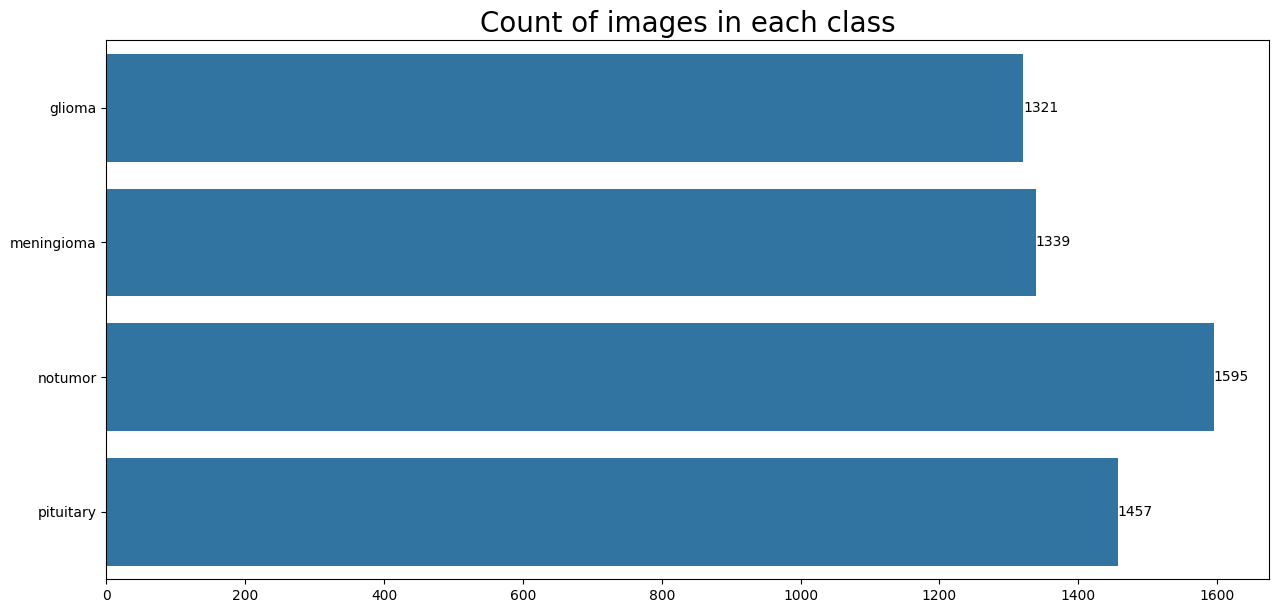

In [7]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

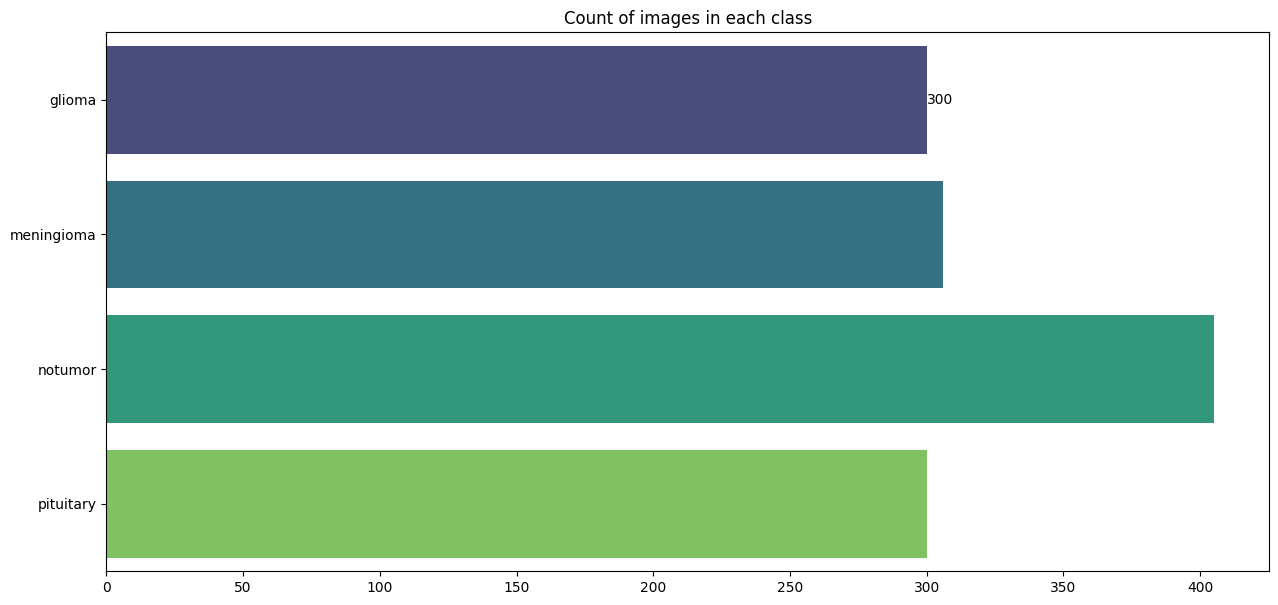

In [8]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [9]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [10]:
valid_df

,Class Path,Class
286,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,glioma
318,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,meningioma
1072,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,pituitary
373,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,meningioma
109,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,glioma
...,...,...
59,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,glioma
860,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,notumor
273,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,glioma
494,C:\Users\srkvi\OneDrive\Desktop\project\Testin...,meningioma


# **CNN**

## Data Preprocessing

In [11]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


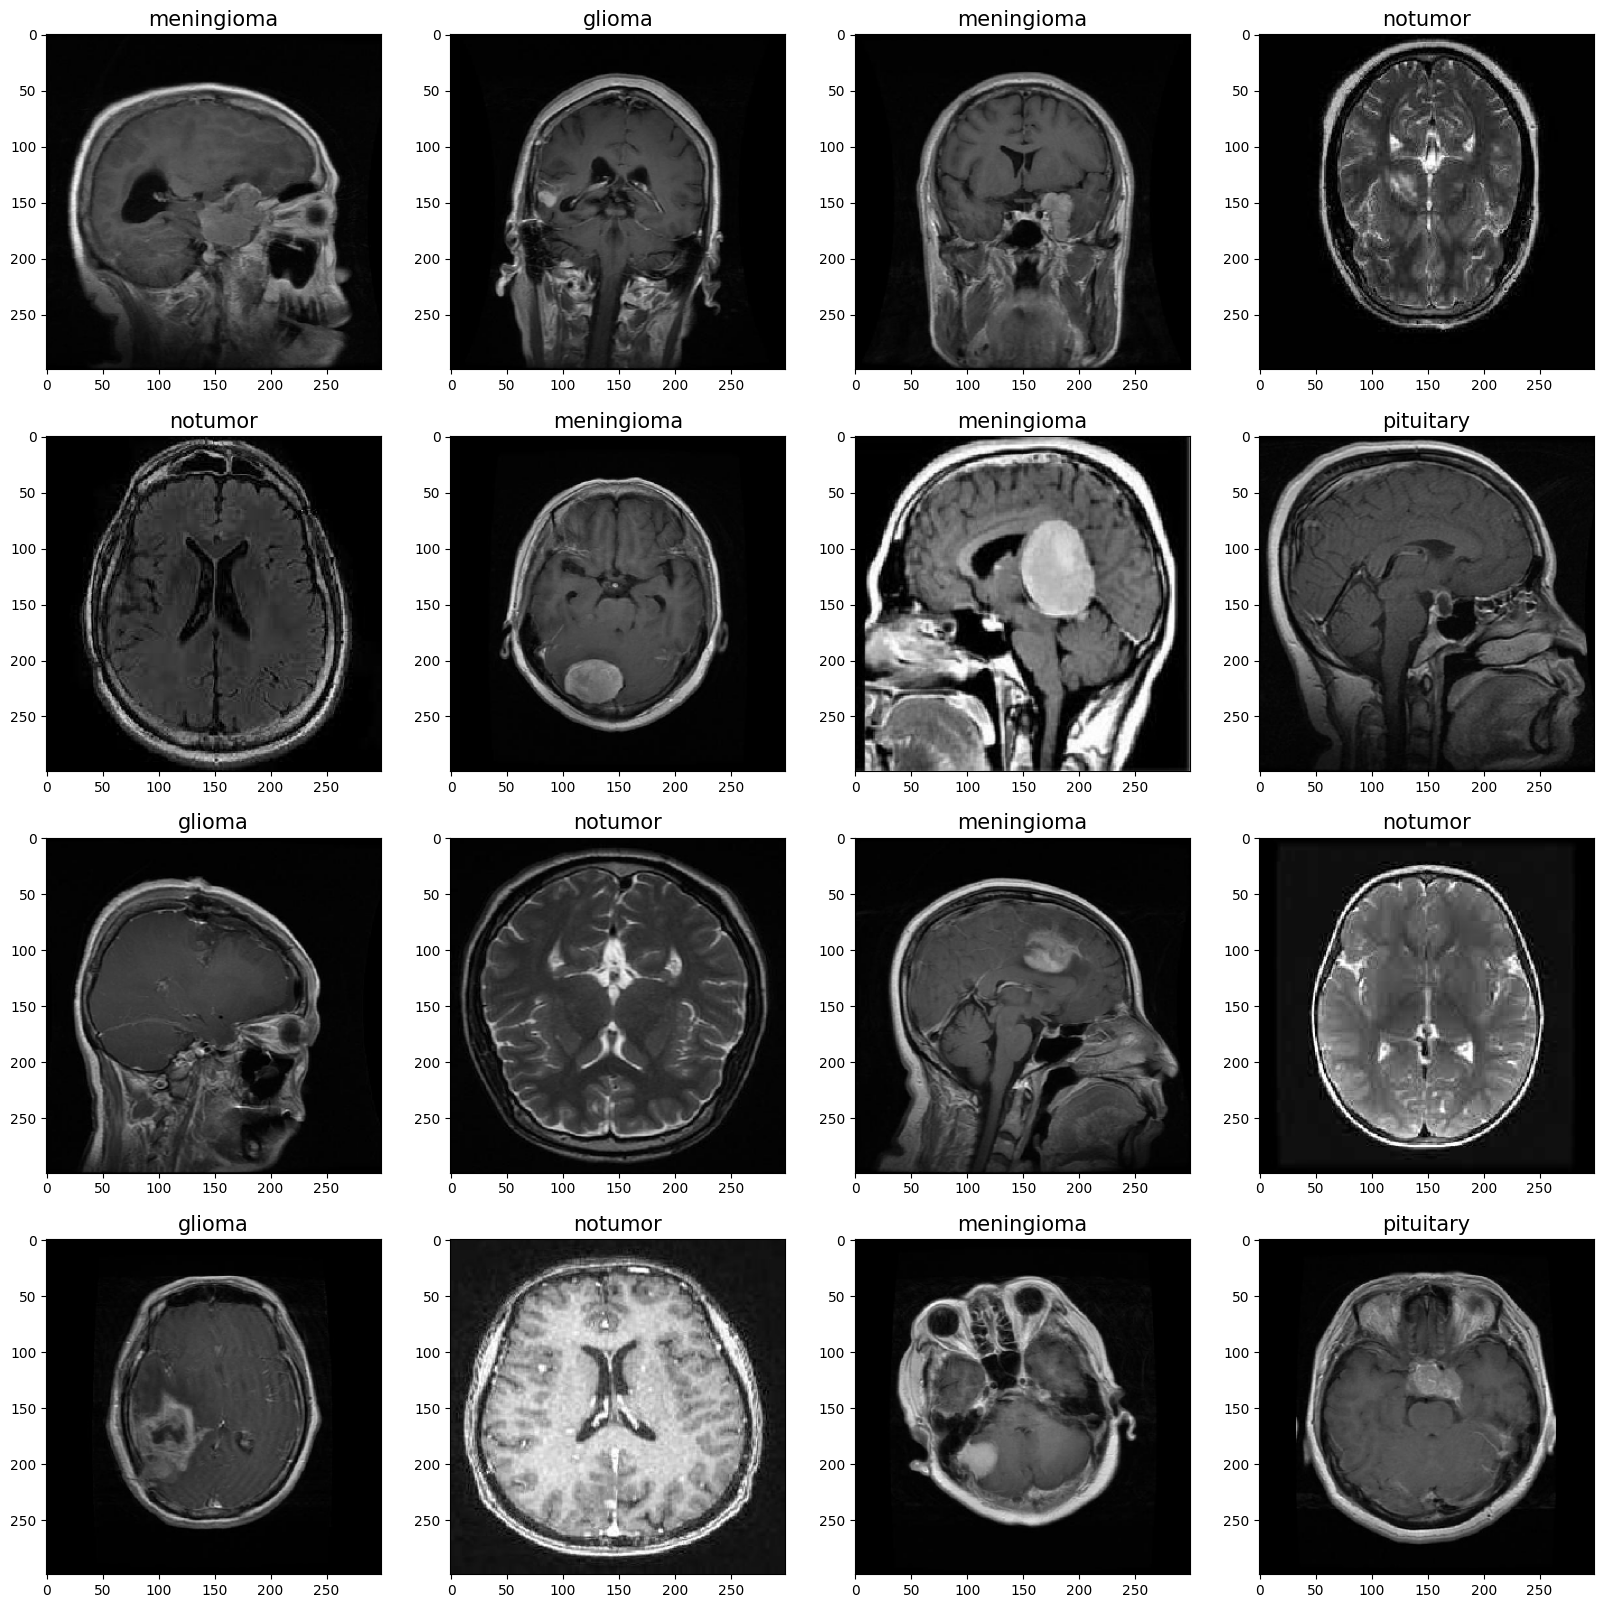

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

## Building a Deep Learning Model

In [13]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Training

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1412s 8s/step - accuracy: 0.8204 - loss: 0.5573 - precision: 0.8573 - recall: 0.7515 - val_accuracy: 0.9634 - val_loss: 0.1132 - val_precision: 0.9677 - val_recall: 0.9618
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3222s 18s/step - accuracy: 0.9765 - loss: 0.0610 - precision: 0.9789 - recall: 0.9753 - val_accuracy: 0.9740 - val_loss: 0.0818 - val_precision: 0.9740 - val_recall: 0.9725
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 6832s 38s/step - accuracy: 0.9931 - loss: 0.0273 - precision: 0.9931 - recall: 0.9930 - val_accuracy: 0.9878 - val_loss: 0.0405 - val_precision: 0.9878 - val_recall: 0.9878
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1815s 10s/step - accuracy: 0.9931 - loss: 0.0212 - precision: 0.9931 - recall: 0.9926 - val_accuracy: 0.9954 - val_loss: 0.0289 - val_precision: 0.9954 - val_recall: 0.9954
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 30864s 173s/step - accuracy: 0.9984 - loss: 0.0059 - precision: 0.9985 - recall: 0.9984 - val_accuracy: 0.986

In [20]:
hist.history.keys()
model.save("model.h5")
import pickle

# Save the trained model using pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [19]:
import joblib

# Save the trained model using joblib
joblib.dump(model, "model.joblib")


['model.joblib']

## Visualize

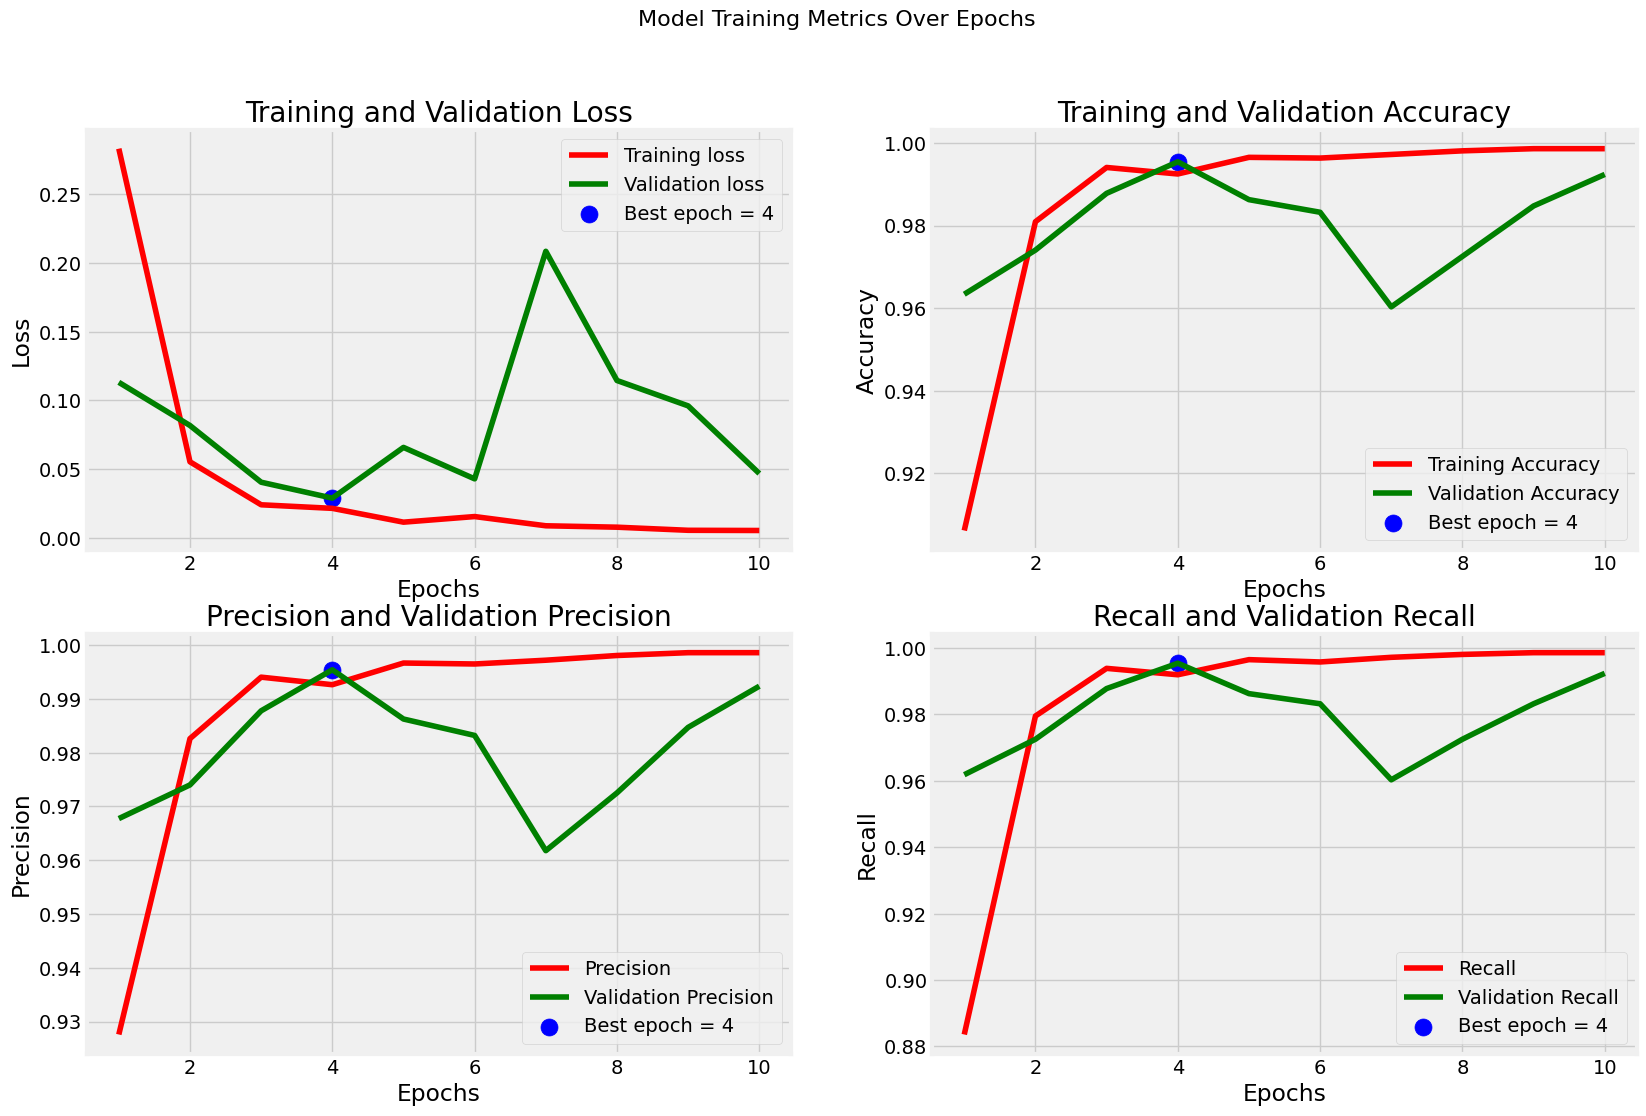

In [21]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9982 - loss: 0.0045 - precision: 0.9982 - recall: 0.9982
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9918 - loss: 0.0317 - precision: 0.9918 - recall: 0.9918
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 928ms/step - accuracy: 0.9920 - loss: 0.0174 - precision: 0.9920 - recall: 0.9920
Train Loss: 0.0041
Train Accuracy: 99.84%
--------------------
Validation Loss: 0.0441
Validation Accuracy: 99.39%
--------------------
Test Loss: 0.0352
Test Accuracy: 98.93%


In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 895ms/step


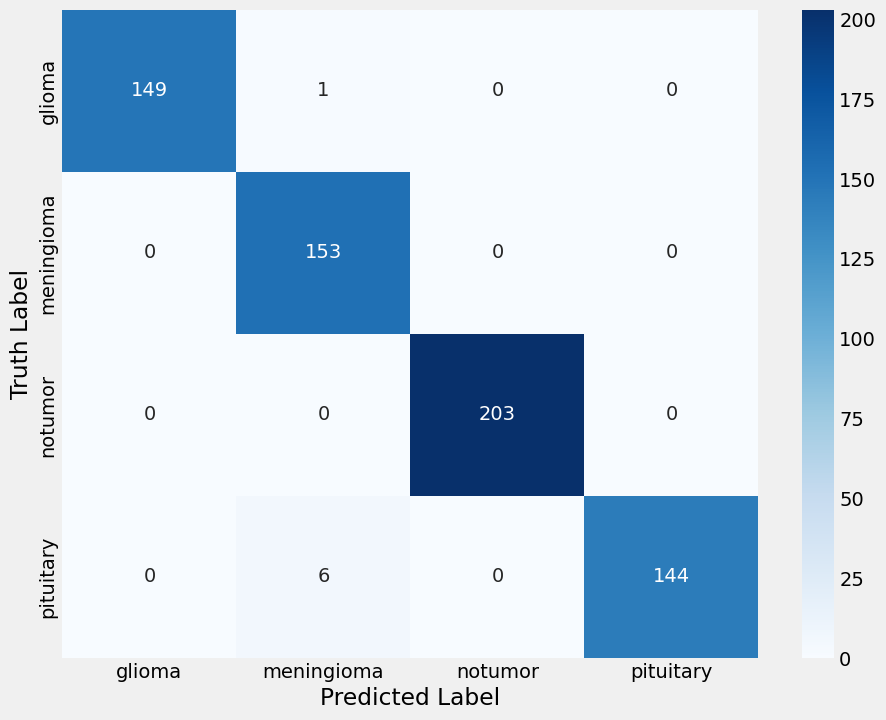

In [24]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [25]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.96      1.00      0.98       153
           2       1.00      1.00      1.00       203
           3       1.00      0.96      0.98       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



Result

In [26]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


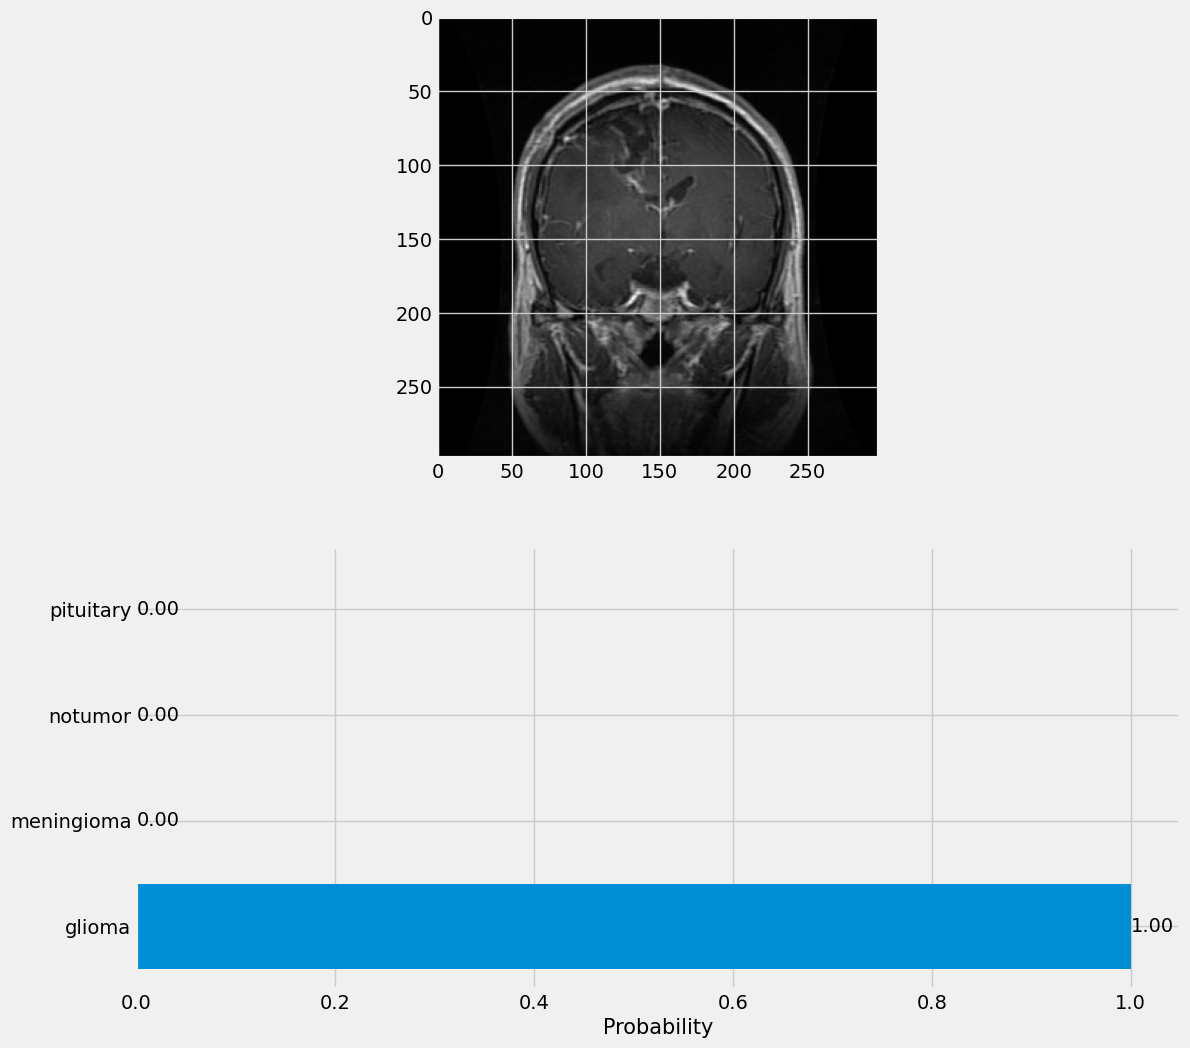

In [28]:
predict(r'C:\Users\srkvi\OneDrive\Desktop\project\Training\glioma\Tr-gl_0013.jpg')

# **VGG16**

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
from sklearn.utils import shuffle

train_dir = r'C:\Users\srkvi\OneDrive\Desktop\project\Training'
test_dir = r'C:\Users\srkvi\OneDrive\Desktop\project\Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)  # Construct full path to the label directory
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            image_path = os.path.join(label_path, image)  # Construct full path to the image
            train_paths.append(image_path)
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


In [8]:


test_dir = r'C:\Users\srkvi\OneDrive\Desktop\project\Testing'

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)  # Construct full path to the label directory
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            image_path = os.path.join(label_path, image)  # Construct full path to the image
            test_paths.append(image_path)
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)




([<matplotlib.patches.Wedge at 0x1b80efbfe50>,
 [Text(0.27380282146496243, 1.091172312221047, 'pituitary'),
  Text(-1.1142970581685328, 0.1548130038367383, 'notumor'),
  Text(-0.10688197279608173, -1.1199112660792452, 'meningioma'),
  Text(1.1019108950056995, -0.2267540065086801, 'glioma')],
 [Text(0.1521126785916458, 0.6062068401228038, '25.5%'),
  Text(-0.6190539212047402, 0.0860072243537435, '27.9%'),
  Text(-0.05937887377560096, -0.6221729255995806, '23.4%'),
  Text(0.6121727194476108, -0.12597444806037783, '23.1%')])

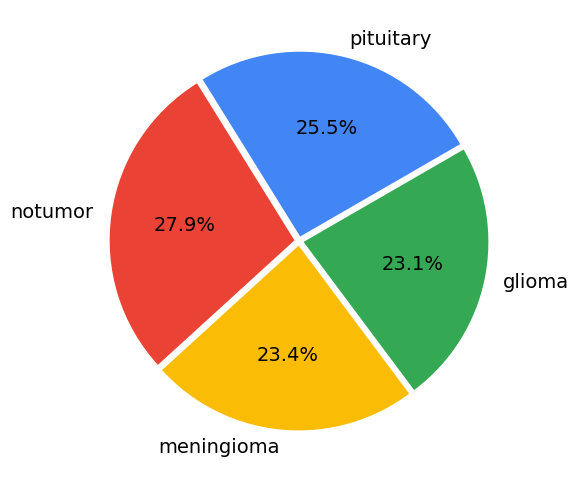

In [9]:


plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30)



## DATA AUGMENTATION

In [10]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

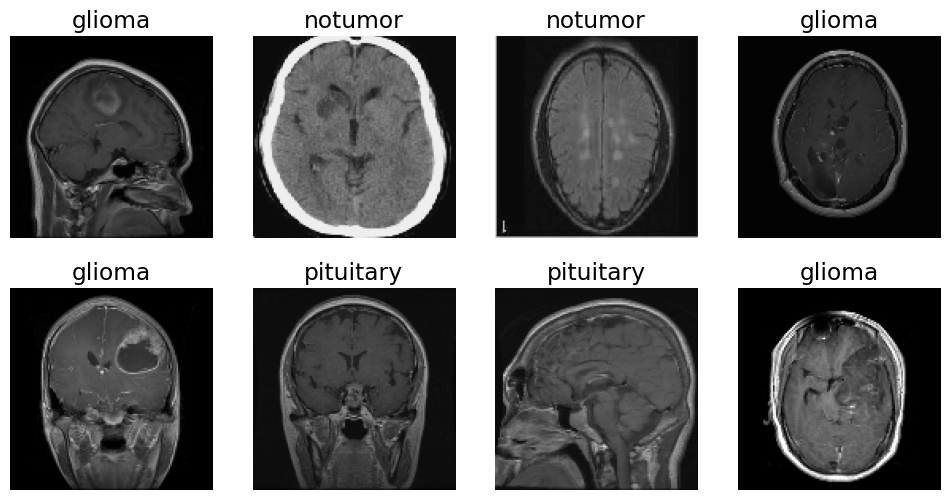

In [11]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [12]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## Training

In [13]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:


batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)



Epoch 1/4


285/285 [==============================] - 259s 898ms/step - loss: 0.4446 - sparse_categorical_accuracy: 0.8258
Epoch 2/4
285/285 [==============================] - 398s 1s/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9155
Epoch 3/4
285/285 [==============================] - 477s 2s/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9418
Epoch 4/4
285/285 [==============================] - 519s 2s/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9589


### Results

In [ ]:


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)



  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▎         | 1/40 [00:01<00:56,  1.45s/it]

1/1 [==============================] - 1s 759ms/step


  5%|▌         | 2/40 [00:02<00:44,  1.16s/it]

1/1 [==============================] - 1s 755ms/step


  8%|▊         | 3/40 [00:03<00:38,  1.04s/it]

1/1 [==============================] - 1s 803ms/step


 10%|█         | 4/40 [00:04<00:36,  1.01s/it]

1/1 [==============================] - 1s 777ms/step


 12%|█▎        | 5/40 [00:05<00:34,  1.02it/s]

1/1 [==============================] - 1s 778ms/step


 15%|█▌        | 6/40 [00:06<00:32,  1.05it/s]

1/1 [==============================] - 1s 790ms/step


 18%|█▊        | 7/40 [00:07<00:31,  1.05it/s]

1/1 [==============================] - 1s 823ms/step


 20%|██        | 8/40 [00:08<00:30,  1.05it/s]

1/1 [==============================] - 1s 801ms/step


 22%|██▎       | 9/40 [00:08<00:29,  1.05it/s]

1/1 [==============================] - 1s 810ms/step


 25%|██▌       | 10/40 [00:09<00:28,  1.04it/s]

1/1 [==============================] - 1s 829ms/step


 28%|██▊       | 11/40 [00:10<00:27,  1.04it/s]

1/1 [==============================] - 1s 829ms/step


 30%|███       | 12/40 [00:11<00:26,  1.04it/s]

1/1 [==============================] - 1s 912ms/step


 32%|███▎      | 13/40 [00:12<00:26,  1.01it/s]

1/1 [==============================] - 1s 837ms/step


 35%|███▌      | 14/40 [00:13<00:25,  1.01it/s]

1/1 [==============================] - 1s 850ms/step


 38%|███▊      | 15/40 [00:14<00:24,  1.02it/s]

1/1 [==============================] - 1s 955ms/step


 40%|████      | 16/40 [00:15<00:24,  1.02s/it]

1/1 [==============================] - 1s 907ms/step


 42%|████▎     | 17/40 [00:17<00:23,  1.02s/it]

1/1 [==============================] - 1s 923ms/step


 45%|████▌     | 18/40 [00:18<00:22,  1.04s/it]

1/1 [==============================] - 1s 947ms/step


 48%|████▊     | 19/40 [00:19<00:22,  1.06s/it]

1/1 [==============================] - 1s 972ms/step


 50%|█████     | 20/40 [00:20<00:21,  1.08s/it]

1/1 [==============================] - 1s 881ms/step


 52%|█████▎    | 21/40 [00:21<00:20,  1.07s/it]

1/1 [==============================] - 1s 887ms/step


 55%|█████▌    | 22/40 [00:22<00:18,  1.05s/it]

1/1 [==============================] - 1s 888ms/step


 57%|█████▊    | 23/40 [00:23<00:17,  1.04s/it]

1/1 [==============================] - 1s 906ms/step


 60%|██████    | 24/40 [00:24<00:16,  1.04s/it]

1/1 [==============================] - 1s 907ms/step


 62%|██████▎   | 25/40 [00:25<00:15,  1.05s/it]

1/1 [==============================] - 1s 907ms/step


 65%|██████▌   | 26/40 [00:26<00:14,  1.05s/it]

1/1 [==============================] - 1s 902ms/step


 68%|██████▊   | 27/40 [00:27<00:13,  1.05s/it]

1/1 [==============================] - 1s 929ms/step


 70%|███████   | 28/40 [00:28<00:12,  1.06s/it]

1/1 [==============================] - 1s 931ms/step


 72%|███████▎  | 29/40 [00:29<00:11,  1.06s/it]

1/1 [==============================] - 1s 926ms/step


 75%|███████▌  | 30/40 [00:30<00:10,  1.06s/it]

1/1 [==============================] - 1s 924ms/step


 78%|███████▊  | 31/40 [00:31<00:09,  1.06s/it]

1/1 [==============================] - 1s 928ms/step


 80%|████████  | 32/40 [00:32<00:08,  1.07s/it]

1/1 [==============================] - 1s 927ms/step


 82%|████████▎ | 33/40 [00:34<00:07,  1.07s/it]

1/1 [==============================] - 1s 933ms/step


 85%|████████▌ | 34/40 [00:35<00:06,  1.07s/it]

1/1 [==============================] - 1s 941ms/step


 88%|████████▊ | 35/40 [00:36<00:05,  1.08s/it]

1/1 [==============================] - 1s 951ms/step


 90%|█████████ | 36/40 [00:37<00:04,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▎| 37/40 [00:38<00:03,  1.11s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 38/40 [00:39<00:02,  1.19s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 39/40 [00:41<00:01,  1.21s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 40/40 [00:42<00:00,  1.20s/it]

1/1 [==============================] - 1s 1s/step


41it [00:43,  1.07s/it]                        


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       300
  meningioma       0.83      0.94      0.88       306
     notumor       1.00      0.94      0.97       405
   pituitary       0.99      0.95      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.94      1311



In [ ]:
# Save the model
model.save("my_model.h5")
print("Model saved successfully.")


c:\Users\srkvi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [ ]:
# Calculate test accuracy
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", test_accuracy)



Test Accuracy: 0.9344012204424104


## **VGG16 with k fold cross validation**

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [ ]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
k_folds = 5

# Combine train_paths and train_labels for StratifiedKFold
train_data = list(zip(train_paths, train_labels))

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store the test accuracies
test_accuracies = []

# Define batch size and number of epochs
batch_size = 32
epochs = 10

# Define your model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(unique_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(train_paths, train_labels)):
    print(f"Fold {fold_idx + 1}/{k_folds}")
    
    # Split data into train and validation sets for this fold
    fold_train_paths = [train_paths[i] for i in train_index]
    fold_train_labels = [train_labels[i] for i in train_index]
    fold_test_paths = [train_paths[i] for i in test_index]
    fold_test_labels = [train_labels[i] for i in test_index]
    
    # Train the model on the training data for this fold
    history = model.fit(datagen(fold_train_paths, fold_train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=len(train_index)//batch_size, verbose=0)
    
    # Evaluate the model on the test data for this fold
    test_loss, test_accuracy = model.evaluate(datagen(fold_test_paths, fold_test_labels, batch_size=batch_size),
                                               verbose=0)
    
    print(f"Test accuracy for fold {fold_idx + 1}: {test_accuracy}")
    test_accuracies.append(test_accuracy)

# Calculate and print the mean test accuracy across all folds
mean_test_accuracy = np.mean(test_accuracies)
print(f"Mean test accuracy across all folds: {mean_test_accuracy}")




Fold 1/5


Test accuracy for fold 1: 0.9212598204612732
Fold 2/5
Test accuracy for fold 2: 0.9956255555152893
Fold 3/5
Test accuracy for fold 3: 0.9973730444908142
Fold 4/5
Test accuracy for fold 4: 1.0
Fold 5/5
Test accuracy for fold 5: 1.0
Mean test accuracy across all folds: 0.9828516840934753


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


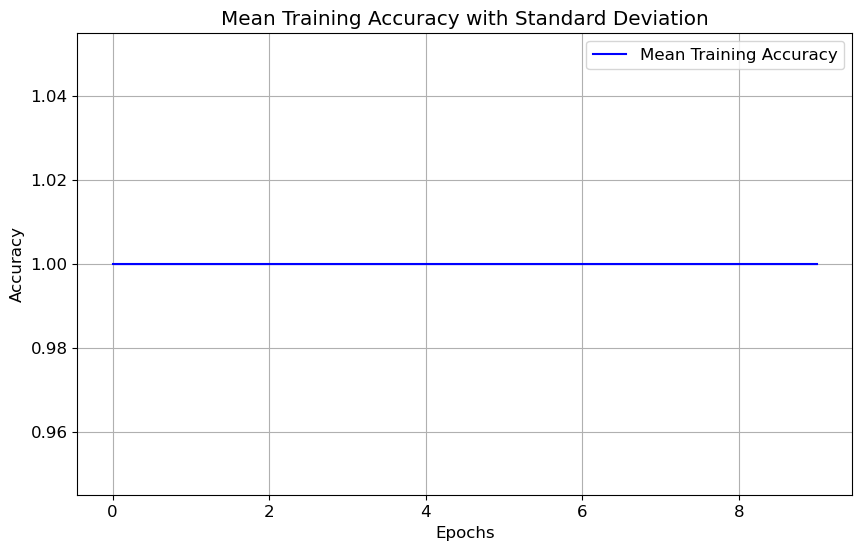

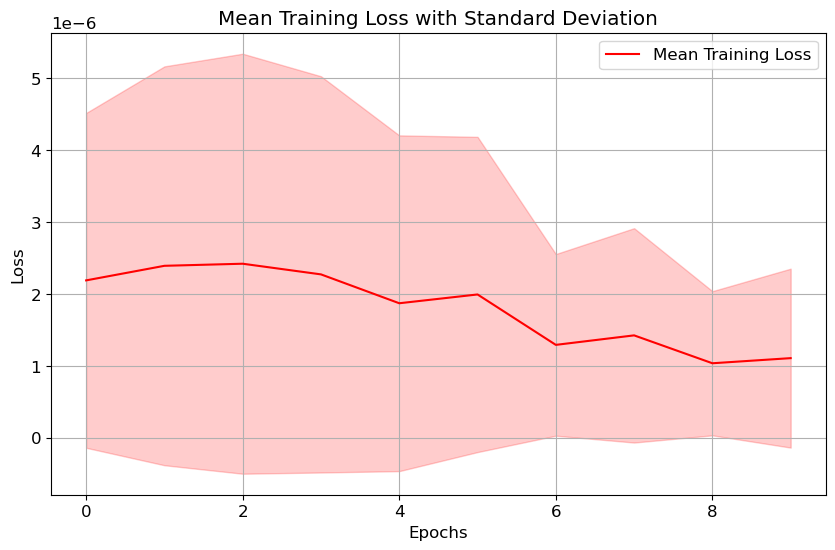

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store training accuracy and loss values for each fold
accuracy_per_fold = []
loss_per_fold = []

# Iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(train_paths, train_labels)):
    print(f"Fold {fold_idx + 1}/{k_folds}")
    
    # Split data into train and validation sets for this fold
    fold_train_paths = [train_paths[i] for i in train_index]
    fold_train_labels = [train_labels[i] for i in train_index]
    fold_test_paths = [train_paths[i] for i in test_index]
    fold_test_labels = [train_labels[i] for i in test_index]
    
    # Train the model on the training data for this fold
    history = model.fit(datagen(fold_train_paths, fold_train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=len(train_index)//batch_size, verbose=0)
    
    # Append training accuracy and loss values for this fold
    accuracy_per_fold.append(history.history['accuracy'])
    loss_per_fold.append(history.history['loss'])

# Convert lists to numpy arrays
accuracy_per_fold = np.array(accuracy_per_fold)
loss_per_fold = np.array(loss_per_fold)

# Calculate mean and standard deviation of training accuracy and loss across all folds
mean_accuracy = np.mean(accuracy_per_fold, axis=0)
std_accuracy = np.std(accuracy_per_fold, axis=0)
mean_loss = np.mean(loss_per_fold, axis=0)
std_loss = np.std(loss_per_fold, axis=0)

# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(mean_accuracy, label='Mean Training Accuracy', color='blue')
plt.fill_between(range(epochs), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='blue', alpha=0.2)
plt.title('Mean Training Accuracy with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(mean_loss, label='Mean Training Loss', color='red')
plt.fill_between(range(epochs), mean_loss - std_loss, mean_loss + std_loss, color='red', alpha=0.2)
plt.title('Mean Training Loss with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize lists to store confusion matrices
confusion_matrices = []

# Iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(train_paths, train_labels)):
    print(f"Fold {fold_idx + 1}/{k_folds}")
    
    # Split data into train and validation sets for this fold
    fold_train_paths = [train_paths[i] for i in train_index]
    fold_train_labels = [train_labels[i] for i in train_index]
    fold_test_paths = [train_paths[i] for i in test_index]
    fold_test_labels = [train_labels[i] for i in test_index]
    
    # Generate predictions for the test set
    fold_predictions = model.predict(datagen(fold_test_paths, fold_test_labels, batch_size=batch_size))
    
    # Convert predicted labels from one-hot encoding to class labels
    fold_pred_labels = np.argmax(fold_predictions, axis=1)
    
    # Convert string labels to numerical labels for computing confusion matrix
    label_map = {label: i for i, label in enumerate(unique_labels)}
    fold_test_labels_numeric = [label_map[label] for label in fold_test_labels]
    
    # Generate confusion matrix
    fold_confusion_matrix = confusion_matrix(fold_test_labels_numeric, fold_pred_labels)
    print(f"Confusion Matrix for fold {fold_idx + 1}:")
    print(fold_confusion_matrix)
    confusion_matrices.append(fold_confusion_matrix)




Fold 1/5
36/36 [==============================] - 5s 125ms/step
Confusion Matrix for fold 1:
[[264   0   0   0]
 [  0 268   0   0]
 [  0   0 319   0]
 [  0   0   0 292]]
Fold 2/5
36/36 [==============================] - 4s 118ms/step
Confusion Matrix for fold 2:
[[265   0   0   0]
 [  0 267   0   0]
 [  0   0 319   0]
 [  0   0   0 292]]
Fold 3/5
36/36 [==============================] - 4s 110ms/step
Confusion Matrix for fold 3:
[[264   0   0   0]
 [  0 268   0   0]
 [  0   0 319   0]
 [  0   0   0 291]]
Fold 4/5
36/36 [==============================] - 4s 111ms/step
Confusion Matrix for fold 4:
[[264   0   0   0]
 [  0 268   0   0]
 [  0   0 319   0]
 [  0   0   0 291]]
Fold 5/5
36/36 [==============================] - 4s 111ms/step
Confusion Matrix for fold 5:
[[264   0   0   0]
 [  0 268   0   0]
 [  0   0 319   0]
 [  0   0   0 291]]


In [ ]:
# Define a directory to save the models
models_dir = "saved_models"
import joblib

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(train_paths, train_labels)):
    print(f"Fold {fold_idx + 1}/{k_folds}")
    
    # Split data into train and validation sets for this fold
    fold_train_paths = [train_paths[i] for i in train_index]
    fold_train_labels = [train_labels[i] for i in train_index]
    fold_test_paths = [train_paths[i] for i in test_index]
    fold_test_labels = [train_labels[i] for i in test_index]
    
    # Train the model on the training data for this fold
    history = model.fit(datagen(fold_train_paths, fold_train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=len(train_index)//batch_size, verbose=0)
    
    # Evaluate the model on the test data for this fold
    test_loss, test_accuracy = model.evaluate(datagen(fold_test_paths, fold_test_labels, batch_size=batch_size),
                                               verbose=0)
    
    print(f"Test accuracy for fold {fold_idx + 1}: {test_accuracy}")
    test_accuracies.append(test_accuracy)
    
    # Save the model
    model_path = os.path.join(models_dir, f"model_fold_{fold_idx + 1}.joblib")
    model.save(model_path)
